In [1]:
import sys
from pathlib import Path
sys.path.append("../src/")
sys.path.append("../src/AtomicH")
sys.path.append("../src/AtomicH/LitReview")
import numpy as np
import pylab as plt
import json
import os
import elastic
import constants
import potentials
import dipolelosses
from dipolelosses import DipoleChannels
import spinexchange
from spinexchange import SpinExChannels


try:
    here = Path(__file__).resolve().parent
except NameError:
    here = Path.cwd()              

src_root = (here / ".." / "src").resolve()
if str(src_root) not in sys.path:    
    sys.path.insert(0, str(src_root))

In [2]:
k_A  = np.linspace(1e-4, 4*constants.hcInEVAngstrom, 200)      
k_eV = k_A / constants.hcInEVAngstrom           

In [3]:
r0       = 1e-9
intlimit = 100 * constants.BohrInAng/constants.hcInEVAngstrom
rhos = np.linspace(r0, intlimit, 100)

muH=constants.HydrogenConstants.mu
muT=constants.TritiumConstants.mu

even_ls = np.arange(0, 16, 2)   

sigma_T_by_l = {}               
sigma_T_total = np.zeros_like(k_A)   # activate if you want Σ_l

for l in even_ls:
    sigma_T_partial = np.array([
        elastic.GetCrossSection(rhos, k, l, muT,
                                potentials.Silvera_Triplet, 'Radau')
        for k in k_A
    ])
    sigma_T_by_l[l] = sigma_T_partial 
    sigma_T_total   += sigma_T_by_l[l]       

In [4]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Al_Maaitah_EX.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

Al_Maaitah        = data["datasetColl"][0]["data"]     # first dataset in the file
k        = np.array([pt["value"][0] for pt in Al_Maaitah])   # Å⁻¹
XS      = np.array([pt["value"][1] for pt in Al_Maaitah])   # Å²

from scipy.signal import savgol_filter
XS_smooth = savgol_filter(XS, window_length=5, polyorder=2)


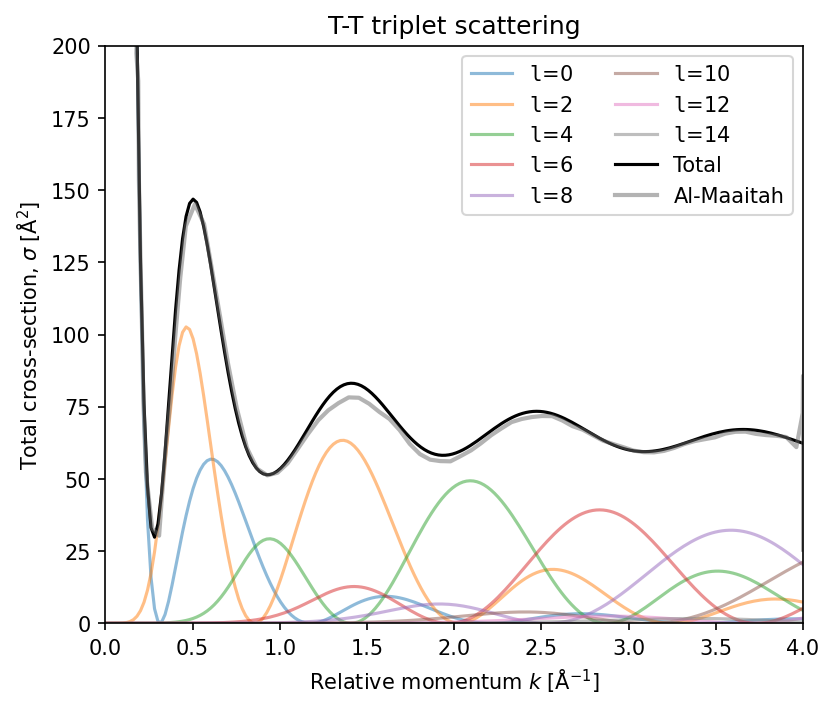

In [5]:


plt.figure(figsize=(6,5), dpi=150)
for l in sigma_T_by_l.keys():
    plt.plot(k_eV, np.array(sigma_T_by_l[l])* constants.hcInEVAngstrom**2,alpha=0.5,label=r'$\mathtt{l}$='+str(l))
plt.plot(k_eV, np.array(sigma_T_total) * constants.hcInEVAngstrom**2, label="Total",color='black')
plt.plot(k,XS_smooth, label="Al-Maaitah",color='dimgrey',linewidth=2,alpha=0.5)
plt.xlabel(r'Relative momentum $k\;[\mathrm{\AA}^{-1}]$')
plt.ylabel(r'Total cross-section, $\sigma\;[\mathrm{\AA}^{2}]$')
plt.xlim(0, 4)
plt.ylim(0, 200)
plt.title("T-T triplet scattering")
plt.legend(ncol=2)

In [6]:
r0       = 1e-9
intlimit = 100 * constants.BohrInAng/constants.hcInEVAngstrom
rhos = np.linspace(r0, intlimit, 100)

muH=constants.HydrogenConstants.mu
muT=constants.TritiumConstants.mu

even_ls = np.arange(0, 16, 2)

sigma_H_by_l = {}
sigma_H_total = np.zeros_like(k_A)   # activate if you want Σ_l

for l in even_ls:
    sigma_H_partial = np.array([
        elastic.GetCrossSection(rhos, k, l, muH,
                                potentials.Silvera_Triplet, 'Radau')
        for k in k_A
    ])
    sigma_H_by_l[l] = sigma_H_partial
    sigma_H_total   += sigma_H_by_l[l]

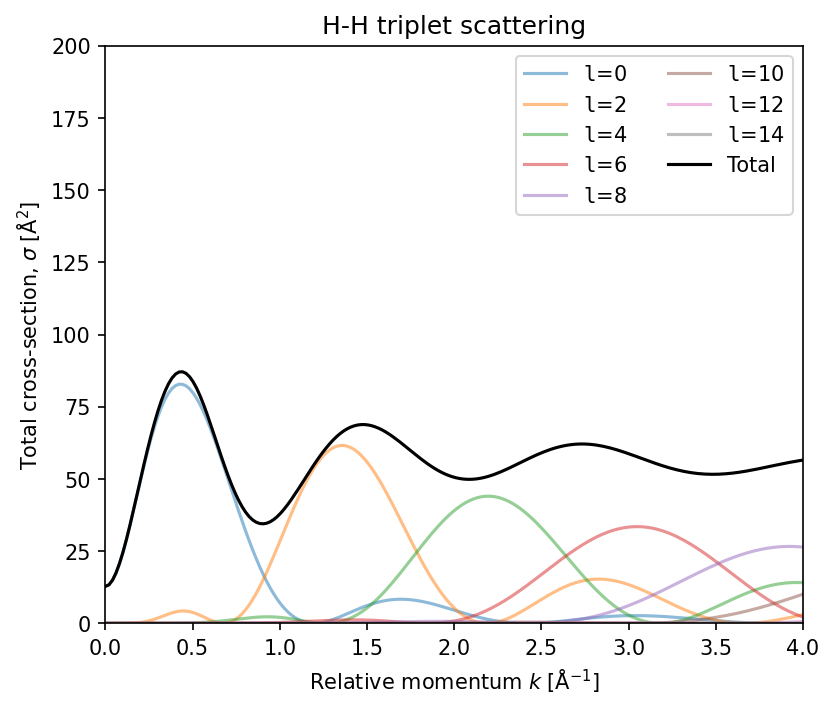

In [7]:

plt.figure(figsize=(6,5), dpi=150)
for l in sigma_H_by_l.keys():
    plt.plot(k_eV, np.array(sigma_H_by_l[l])* constants.hcInEVAngstrom**2,alpha=0.5,label=r'$\mathtt{l}$='+str(l))
plt.plot(k_eV, np.array(sigma_H_total) * constants.hcInEVAngstrom**2, label="Total",color='black')
plt.xlabel(r'Relative momentum $k\;[\mathrm{\AA}^{-1}]$')
plt.ylabel(r'Total cross-section, $\sigma\;[\mathrm{\AA}^{2}]$')
plt.title("H-H triplet scattering")
plt.xlim(0, 4)
plt.ylim(0, 200)
plt.legend(ncol=2)

In [8]:
B_values = np.logspace(-3,1,50)

T   = 5e-5

GVsB_HDip=[]
GVsB_TDip=[]

for c in DipoleChannels:
    Gs=[]
    for B in B_values:
        Gs.append(dipolelosses.GetGFactor(
            c,  B, constants.HydrogenConstants, T, potentials.Silvera_Triplet,rhos=np.linspace(1e-9,0.75,2000),lin=0,lout=2)
        )
    GVsB_HDip.append(np.array(Gs))
    Gs=[]

    for B in B_values:
        Gs.append(dipolelosses.GetGFactor(
            c,  B, constants.TritiumConstants, T, potentials.Silvera_Triplet,rhos=np.linspace(1e-9,0.75,2000),lin=0,lout=2)
        )
    GVsB_TDip.append(np.array(Gs))

/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)
/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)
/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tole

In [9]:
B_values = np.logspace(-3,1,50)
potT     = potentials.Silvera_Triplet
potS     = potentials.Kolos_Singlet2_VDW

T        = 1e-5

GVsB_HEx=[]
GVsB_TEx=[]

for c in SpinExChannels:
    Gs=[]
    for B in B_values:
        Gs.append(spinexchange.GetGFactor(c,  B, constants.HydrogenConstants(), T, potT,potS,np.linspace(1e-9,0.75,2000)))
    GVsB_HEx.append(np.array(Gs))
    Gs=[]

    for B in B_values:
        Gs.append(spinexchange.GetGFactor(c,  B, constants.TritiumConstants(), T, potT,potS,np.linspace(1e-9,0.75,2000)))
    GVsB_TEx.append(np.array(Gs))

In [10]:
# To make the plots with real B on x axis
#B_display=B_values

# To make the plots with Stoof scaled B on x axis
B_display=dipolelosses.B_Naught(B_values)

In [11]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_Exchange_Channels_dd2aa_dd2ad_Mag.json"
)
with open(json_path, "r") as f:
    data = json.load(f)
    
ccaa        = data["datasetColl"][0]["data"]    
B_ccaa        = np.array([pt["value"][0] for pt in ccaa])  
G_ccaa     = np.array([pt["value"][1] for pt in ccaa])  

ccbd        = data["datasetColl"][1]["data"]    
B_ccbd        = np.array([pt["value"][0] for pt in ccbd])  
G_ccbd     = np.array([pt["value"][1] for pt in ccbd])  

ccac      = data["datasetColl"][2]["data"]    
B_ccac        = np.array([pt["value"][0] for pt in ccac])  
G_ccac     = np.array([pt["value"][1] for pt in ccac])  

ddaa        = data["datasetColl"][3]["data"]    
B_ddaa        = np.array([pt["value"][0] for pt in ddaa])  
G_ddaa     = np.array([pt["value"][1] for pt in ddaa])   

ddad        = data["datasetColl"][4]["data"]    
B_ddad      = np.array([pt["value"][0] for pt in ddad])  
G_ddad     = np.array([pt["value"][1] for pt in ddad])   

In [12]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_dd2ac_Mag.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

ddac       = data["datasetColl"][0]["data"]    
B_ddac        = np.array([pt["value"][0] for pt in ddac])  
G_ddac     = np.array([pt["value"][1] for pt in ddac])   

In [13]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_dd2cc_dd2cd_Mag.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

ddcc       = data["datasetColl"][0]["data"]    
B_ddcc        = np.array([pt["value"][0] for pt in ddcc])  
G_ddcc     = np.array([pt["value"][1] for pt in ddcc])  

ddcd       = data["datasetColl"][1]["data"]    
B_ddcd        = np.array([pt["value"][0] for pt in ddcd])  
G_ddcd     = np.array([pt["value"][1] for pt in ddcd])  

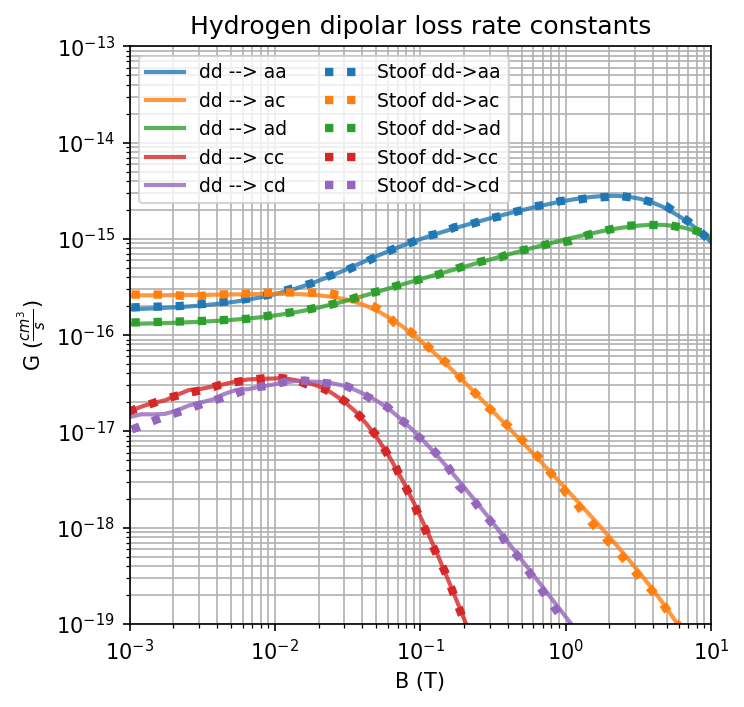

In [14]:
plt.figure(figsize=(5,5),dpi=150)
B_values = np.logspace(-3,1,50)

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

c=0
for ci in range(0,len(DipoleChannels)):
    Label='dd --> '+str(DipoleChannels[ci]['alphaprime'])+str(DipoleChannels[ci]['betaprime'])
    plt.plot(B_values,GVsB_HDip[ci],label=Label,color=colors[c],linewidth=2,alpha=0.8)
    c=c+1
    plt.semilogy()

plt.plot(dipolelosses.Invert_B_Naught(B_ddaa),G_ddaa,':',label="Stoof dd->aa",color=colors[0],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ddac),G_ddac,':',label="Stoof dd->ac",color=colors[1],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ddad),G_ddad,':',label="Stoof dd->ad",color=colors[2],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ddcc),G_ddcc,':',label="Stoof dd->cc",color=colors[3],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ddcd),G_ddcd,':',label="Stoof dd->cd",color=colors[4],linewidth=4)

plt.xlabel("B (T)")
plt.xlim(1e-3, 10)
plt.ylabel(r'G ($\frac{cm^3}{s}$)')
plt.ylim(1e-19, 1e-13)
plt.title("Hydrogen dipolar loss rate constants")
plt.grid(which='both')
plt.legend(ncol=2,fontsize=9,loc='upper left')
plt.loglog()
plt.show()

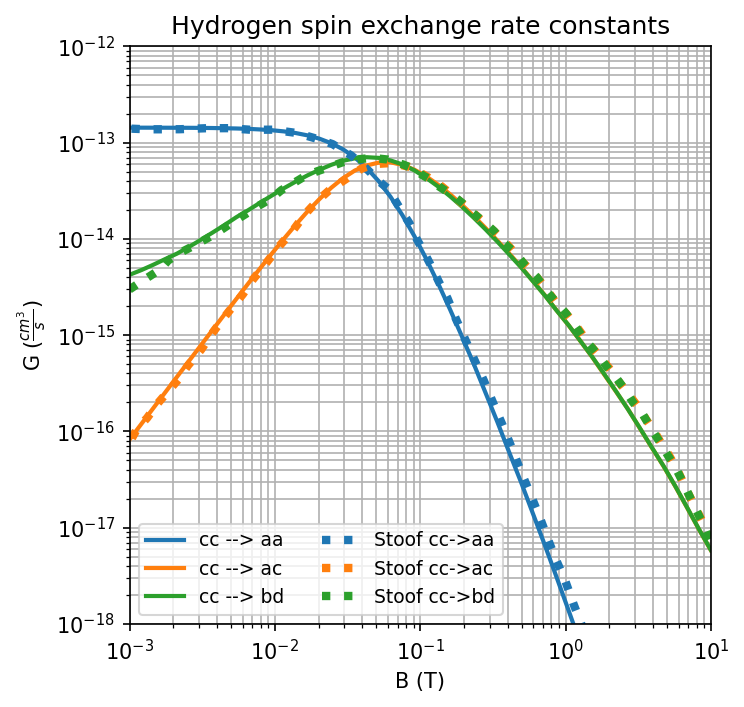

In [15]:
plt.figure(figsize=(5,5),dpi=150)
B_values = np.logspace(-3,1,50)

for ci in range(0,len(SpinExChannels)):
    Label='cc --> '+str(SpinExChannels[ci]['alphaprime'])+str(SpinExChannels[ci]['betaprime'])
    plt.plot(B_values, GVsB_HEx[ci],label=Label,color=colors[ci],linewidth=2)
    plt.semilogy()


plt.plot(dipolelosses.Invert_B_Naught(B_ccaa),G_ccaa,':',label="Stoof cc->aa",color=colors[0],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ccac),G_ccac,':',label="Stoof cc->ac",color=colors[1],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ccbd),G_ccbd,':',label="Stoof cc->bd",color=colors[2],linewidth=4)

plt.xlabel("B (T)")
plt.xlim(1e-3, 10)
plt.ylabel(r'G ($\frac{cm^3}{s}$)')
plt.ylim(1e-18, 1e-12)
plt.title("Hydrogen spin exchange rate constants")
plt.grid(which='both')
plt.legend(ncol=2,fontsize=9,loc='lower left')
plt.loglog()
plt.show()

In [34]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zygelman_Hydrogen_dd2aa.json")

with open(json_path, "r") as f:
    data = json.load(f)
    
ZygaaH        = data["datasetColl"][0]["data"]    
ZygaaKH        = np.array([pt["value"][0] for pt in ZygaaH])  
ZygaaSigH     = np.array([pt["value"][1] for pt in ZygaaH])  

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zygelman_Tritium_dd2aa.json")

with open(json_path, "r") as f:
    data = json.load(f)
    
ZygaaT        = data["datasetColl"][0]["data"]    
ZygaaKT        = np.array([pt["value"][0] for pt in ZygaaT])  
ZygaaSigT     = np.array([pt["value"][1] for pt in ZygaaT])  

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zygelman_Hydrogen_dd2ad.json")

with open(json_path, "r") as f:
    data = json.load(f)
    
ZygadH        = data["datasetColl"][0]["data"]    
ZygadKH        = np.array([pt["value"][0] for pt in ZygadH])  
ZygadSigH     = np.array([pt["value"][1] for pt in ZygadH])  

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zygelman_Tritium_dd2ad.json")

with open(json_path, "r") as f:
    data = json.load(f)
    
ZygadT        = data["datasetColl"][0]["data"]    
ZygadKT        = np.array([pt["value"][0] for pt in ZygadT])  
ZygadSigT     = np.array([pt["value"][1] for pt in ZygadT])  

mp = 1.672621925e-27
me = 9.1093837139e-31
muH = me+mp/2
kb = 1.380649e-23
bohr = 5.29177210544e-9
C = 1e-2 / bohr**2 * np.sqrt(muH/(2*kb))*1e-15

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_aa_ad.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

Stoofaa = data['datasetColl'][0]['data']
Stoofaax = [pt['value'][0] for pt in Stoofaa]
Stoofaay = [pt['value'][1] for pt in Stoofaa]
Stoofaay = [Stoofaay / np.sqrt(Stoofaax)]

Stoofad = data['datasetColl'][1]['data']
Stoofadx = [pt['value'][0] for pt in Stoofad]
Stoofady = [pt['value'][1] for pt in Stoofad]
Stoofady = [Stoofady / np.sqrt(Stoofadx)]

Stoofaay = C * np.array(Stoofaay).flatten()
Stoofady = C * np.array(Stoofady).flatten()

In [17]:
c=DipoleChannels[0]
PWaves= [[0, 2], [2, 0], [2, 2], [2, 4], [4, 2], [4, 4], [4, 6]]
degeneracies =[1, 1, 3, 5, 5, 7, 9]

B_values = np.logspace(-3,100,50)

pot      = potentials.Silvera_Triplet
T_values = np.logspace(-3,2,50)
B_value  = 1e-5

SummedG=[]
for T in T_values:
    SummedG.append(dipolelosses.GetSummedGFactor(c, B_value, constants.HydrogenConstants, T, pot, PWaves, degeneracies,rhos=np.linspace(1e-9,0.75,2000)))
SummedG=np.array(SummedG)

In [18]:
amu=1.672621925e-27
A = 1e-6 / (constants.BohrInAng*1e-10)**2 * np.sqrt(amu/(4*constants.kb))
AT = 1e-6 / (constants.BohrInAng*1e-10)**2 * np.sqrt((3*amu)/(4*constants.kb))


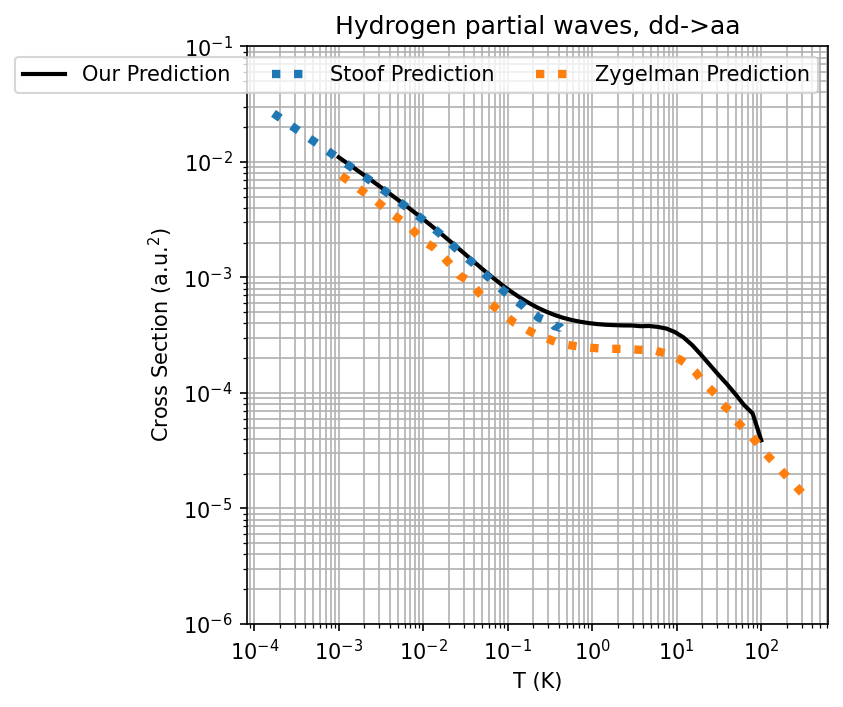

In [19]:


plt.figure(figsize=(5,5),dpi=150)
plt.plot(T_values, A*SummedG/np.sqrt(T_values),linewidth=2,color='black',label='Our Prediction')
plt.plot(Stoofaax,Stoofaay,':', label='Stoof Prediction',linewidth=4)
plt.plot(ZygaaKH, ZygaaSigH,':', label='Zygelman Prediction',linewidth=4)


plt.semilogy()
plt.xlabel("T (K)")
#plt.xlim(0.001, 10)
plt.ylabel(r'Cross Section (a.u.$^2$)')
#plt.ylim(1e-19, 1e-15)
plt.title("Hydrogen partial waves, dd->aa")
plt.grid(which='both')
plt.legend(ncol=3)
plt.loglog()
plt.ylim(1e-6,1e-1)

plt.show()

In [30]:
channels = [DipoleChannels[0], DipoleChannels[2]]
channel_labels = ['dd->aa', 'dd->ad']

pot = potentials.Silvera_Triplet
T_values = np.logspace(-3, 2, 50)
B_values = [1e-3, 1e-1, 1e1]

amu = 1.672621925e-27
A = 1e-6 / (constants.BohrInAng * 1e-10)**2 * np.sqrt(amu / (4 * constants.kb))

In [31]:
CrossSectionArraysH = []

for c in channels:
    CrossSectionArray = np.zeros((len(B_values), len(T_values)))
    for i, B_value in enumerate(B_values):
        for j, T in enumerate(T_values):
            G = dipolelosses.GetSummedGFactor(
                c, B_value, constants.HydrogenConstants, T, pot,
                rhos=np.linspace(1e-9, 0.75, 2000)
            )
            CrossSectionArray[i, j] = A * G / np.sqrt(T)
    CrossSectionArraysH.append(CrossSectionArray)

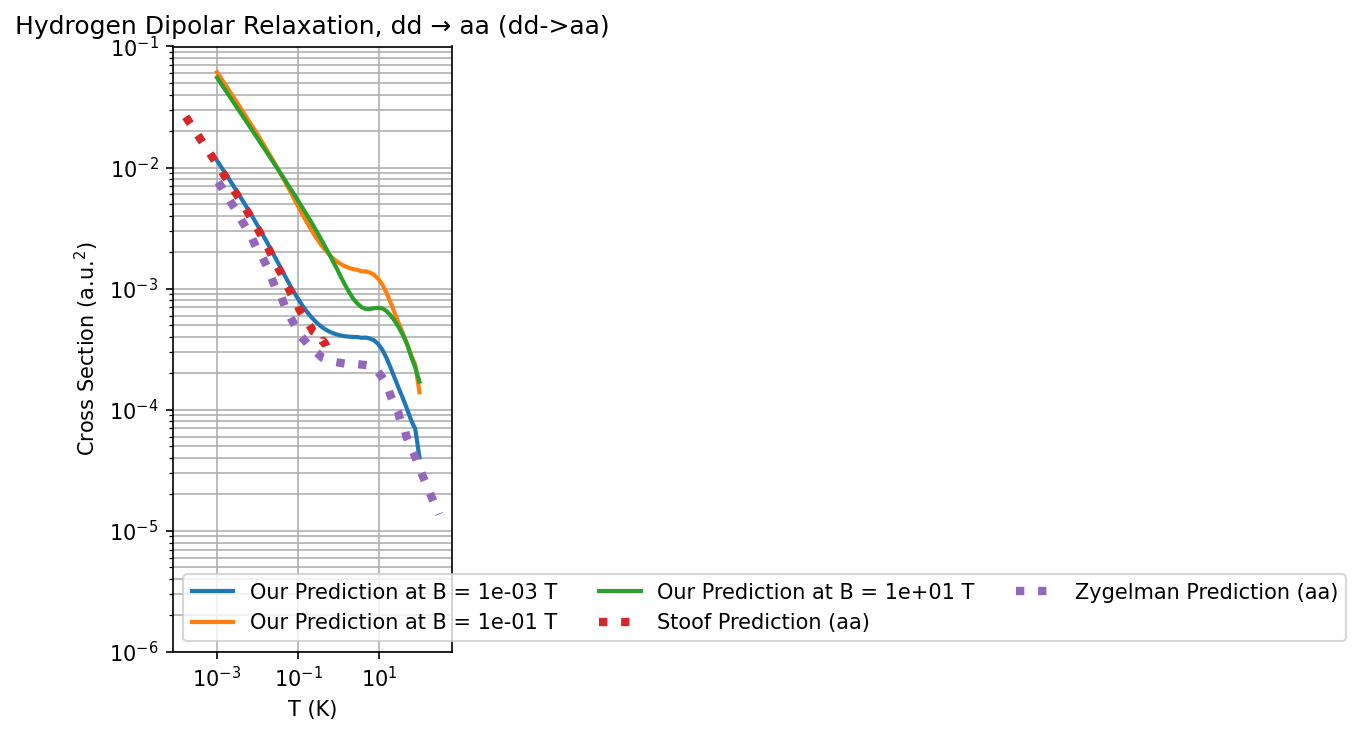

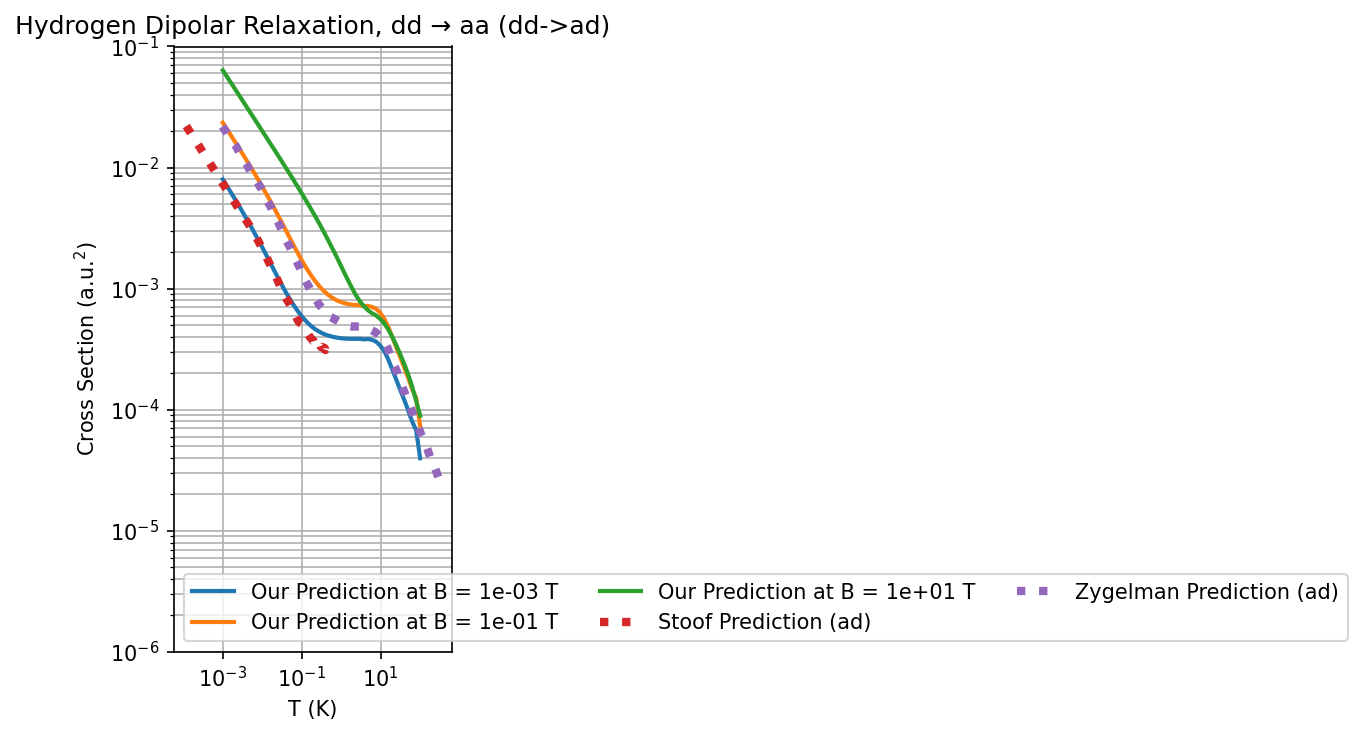

In [35]:
for idx, (channel_label, CrossSectionArray) in enumerate(zip(channel_labels, CrossSectionArraysH)):
    plt.figure(figsize=(6, 5), dpi=150)

    for i, B_value in enumerate(B_values):
        plt.plot(T_values, CrossSectionArray[i, :], linewidth=2,
                 label=f"Our Prediction at B = {B_value:.0e} T")

    if idx == 0:  
        plt.plot(Stoofaax, Stoofaay, ':', label='Stoof Prediction (aa)', linewidth=4)
        plt.plot(ZygaaKH, ZygaaSigH, ':', label='Zygelman Prediction (aa)', linewidth=4)
    elif idx == 1:  
        plt.plot(Stoofadx, Stoofady, ':', label='Stoof Prediction (ad)', linewidth=4)
        plt.plot(ZygadKH, ZygadSigH, ':', label='Zygelman Prediction (ad)', linewidth=4)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("T (K)")
    plt.ylabel(r'Cross Section (a.u.$^2$)')
    plt.title(f"Hydrogen Dipolar Relaxation, dd → aa ({channel_label})")
    plt.grid(which='both')
    plt.legend(ncol=3)
    plt.ylim(1e-6, 1e-1)
    plt.tight_layout()
    plt.show()

In [36]:
CrossSectionArraysT = []

for c in channels:
    CrossSectionArray = np.zeros((len(B_values), len(T_values)))
    for i, B_value in enumerate(B_values):
        for j, T in enumerate(T_values):
            G = dipolelosses.GetSummedGFactor(
                c, B_value, constants.TritiumConstants, T, pot,
                rhos=np.linspace(1e-9, 0.75, 2000)
            )
            CrossSectionArray[i, j] = A * G / np.sqrt(T)
    CrossSectionArraysT.append(CrossSectionArray)

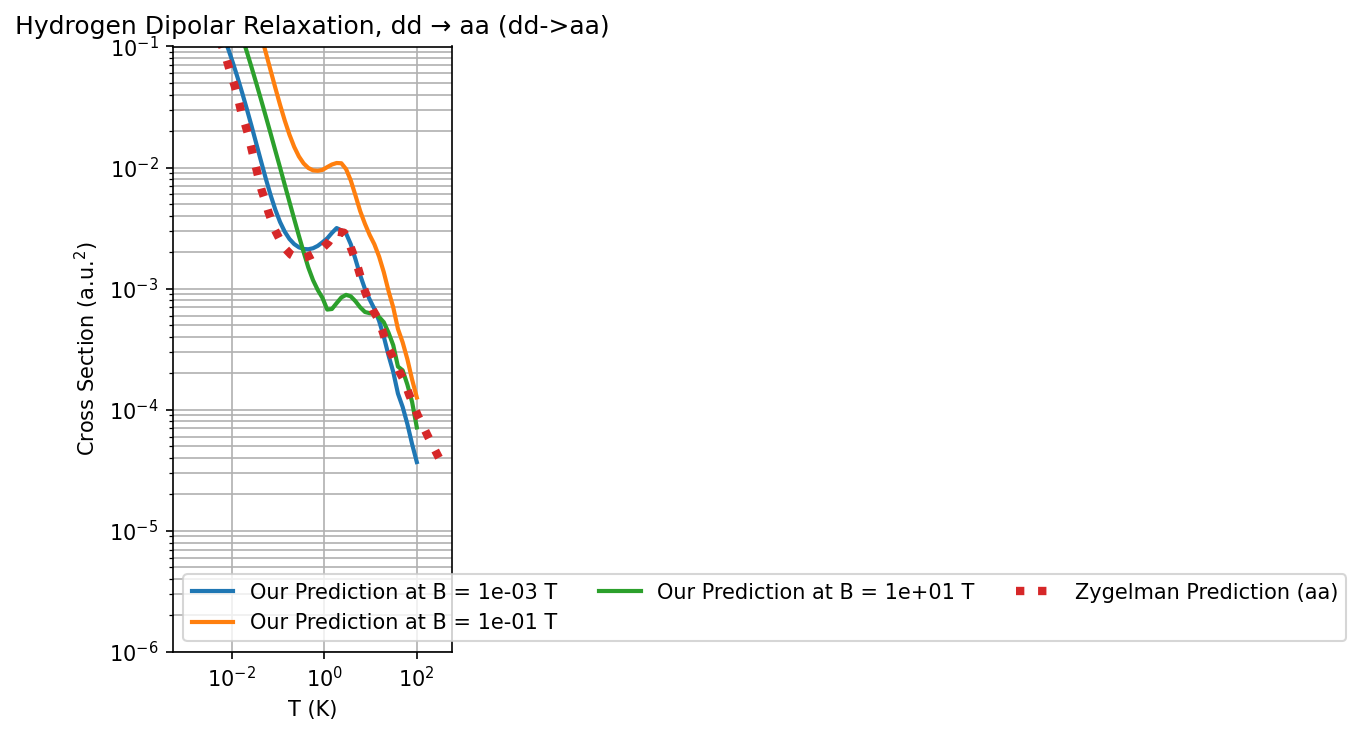

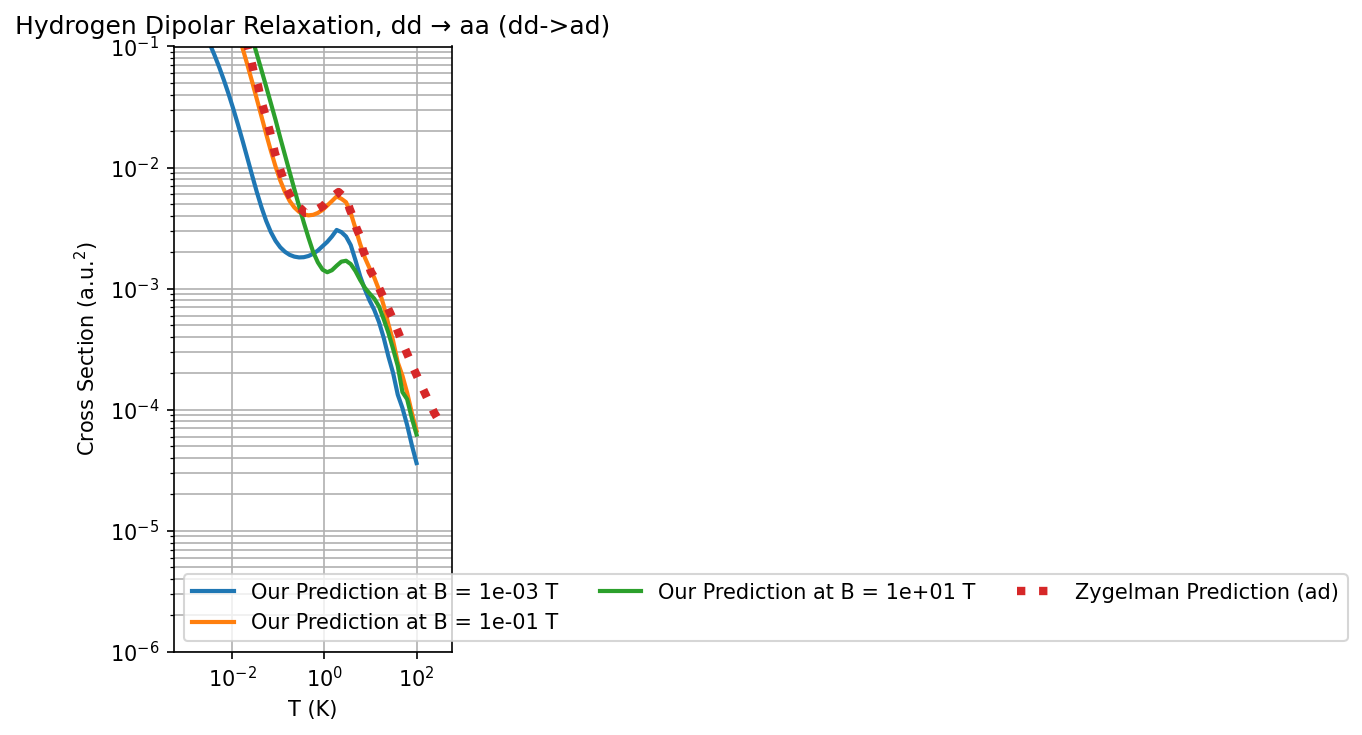

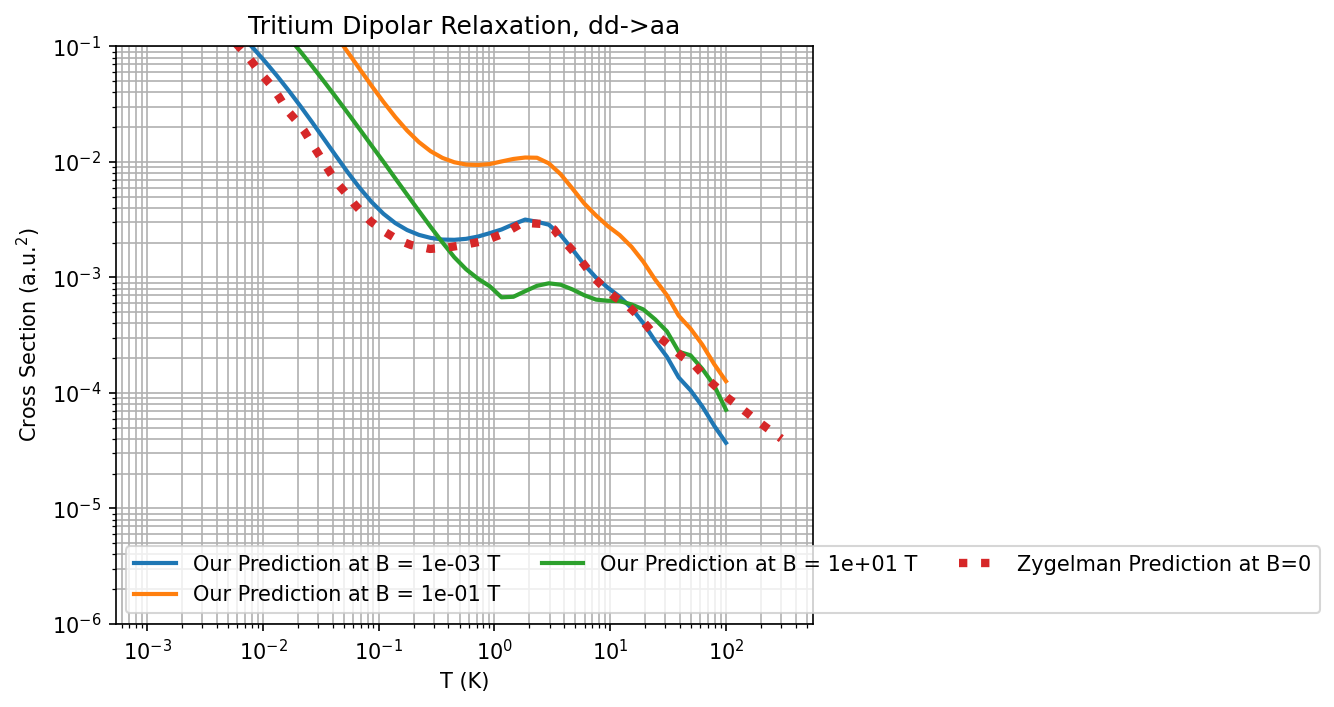

In [37]:
for idx, (channel_label, CrossSectionArray) in enumerate(zip(channel_labels, CrossSectionArraysT)):
    plt.figure(figsize=(6, 5), dpi=150)

    for i, B_value in enumerate(B_values):
        plt.plot(T_values, CrossSectionArray[i, :], linewidth=2,
                 label=f"Our Prediction at B = {B_value:.0e} T")

    if idx == 0:  
        plt.plot(ZygaaKT, ZygaaSigT, ':', label='Zygelman Prediction (aa)', linewidth=4)
    elif idx == 1:  
        plt.plot(ZygadKT, ZygadSigT, ':', label='Zygelman Prediction (ad)', linewidth=4)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("T (K)")
    plt.ylabel(r'Cross Section (a.u.$^2$)')
    plt.title(f"Hydrogen Dipolar Relaxation, dd → aa ({channel_label})")
    plt.grid(which='both')
    plt.legend(ncol=3)
    plt.ylim(1e-6, 1e-1)
    plt.tight_layout()
    plt.show()



plt.figure(figsize=(6, 5), dpi=150)

for i, B_value in enumerate(B_values):
    plt.plot(T_values, CrossSectionArrayT[i, :], linewidth=2,
             label=f"Our Prediction at B = {B_value:.0e} T")

plt.plot(ZygaaKT, ZygaaSigT,':', label='Zygelman Prediction at B=0',linewidth=4)




plt.semilogy()
plt.xlabel("T (K)")
#plt.xlim(0.001, 10)
plt.ylabel(r'Cross Section (a.u.$^2$)')
#plt.ylim(1e-19, 1e-15)
plt.title("Tritium Dipolar Relaxation, dd->aa")
plt.grid(which='both')
plt.legend(ncol=3)
plt.loglog()
plt.ylim(1e-6,1e-1)

plt.show()